In [1]:
import numpy as np
import pandas as pd
import random
from joblib import Parallel, delayed

In [2]:
# 生成随机矩阵X_n
n = 1000    # 样本量
p = 1000    # 变量数

# 创建协方差矩阵
cov_matrix = np.full((p, p), 0.5)  # 创建一个所有元素都是 0.5 的矩阵
np.fill_diagonal(cov_matrix, 2.0)  # 将对角线元素设置为 2.0

mean_vector                = np.zeros(p)  # 均值向量
X                          = np.random.multivariate_normal(mean_vector, cov_matrix, n)
# 奇异值分解
U, S, Vt = np.linalg.svd(X)

# 计算条件数
condition_number = S[0] / S[-1]
print("条件数:", condition_number)

print("最大奇异值:", S[0])
print("最小奇异值:", S[-1])

# 打印奇异值
# S_adjusted = np.copy(S)
# for i in range(len(S)):
#         S_adjusted[i] /= 10**(0.00225*i)   # 或者选择其他缩放因子
# print("最大奇异值:", np.max(S_adjusted))
# print("最小奇异值:", np.min(S_adjusted))
# print("条件数:", np.max(S_adjusted)/np.min(S_adjusted))
# Sigma = np.zeros((U.shape[0], Vt.shape[0]))
# np.fill_diagonal(Sigma, S_adjusted)
# X =  U @ Sigma @ Vt

条件数: 31458.481498308025
最大奇异值: 680.3325852308632
最小奇异值: 0.021626364427903312


In [3]:

# 定义β向量
beta = np.zeros(p)  # 初始化β向量为0

# 根据条件设置β向量的值
beta[0:5]   = 2.0   # βi = 2.0, i = 1, 2, 3, 4, 5
beta[5:10]  = -2.0  # βi = -2.0, i = 6, 7, 8, 9, 10
beta[10:15] = 1.0   # βi = 1.0, i = 11, 12, 13, 14, 15
beta[15:20] = -1.0  # βi = -1.0, i = 16, 17, 18, 19, 20
# beta[20:25] = 5.0   # βi = 5.0, i = 21, 22, 23, 24, 25

# Generate 20 random indices
indices = np.random.randint(low=0, high=p, size=20)

# Get the indices of non-zero elements in beta
nonzero_indices = np.nonzero(beta)[0]

# print(nonzero_indices)

# 初始化random_beta为零向量
random_beta = np.zeros(p)

# Assign the non-zero elements randomly
# 此处假设的意图是将beta中的非零元素随机分配到random_beta中
# 但这样的操作逻辑上存在问题，因为indices的长度和nonzero_indices可能不同
# 为了简化，这里我们只是简单地复制beta到random_beta
random_beta[indices] = beta[nonzero_indices]

# Print the randomly assigned beta
# print(random_beta)
beta = random_beta
nonzero_indices = np.nonzero(beta)[0]
print(nonzero_indices)

[ 12  34 101 111 133 144 279 283 344 477 540 583 711 822 837 840 904 945
 971 981]


In [4]:
# 生成均值为0方差为4的n维向量en
mean    = 0  # 均值
std_dev = 2  # 标准差，方差为标准差的平方，即4

# 生成向量
e = np.random.normal(mean, std_dev, n)
norm_e = np.linalg.norm(e)
Y = np.dot(X, beta) + e
print(norm_e)

64.1452076477926


In [314]:
from scipy.stats import laplace


# 生成Laplace分布的随机样本
el = laplace.rvs(loc=0, scale=np.sqrt(2), size=1000)
norm_e = np.linalg.norm(el)
Y = np.dot(X, beta) + el
print(norm_e)

61.99992798050699


In [5]:
tau   = 1
delta = tau*norm_e
# delta = 50

In [6]:
s1, s2 = X.shape

In [35]:
# 最小二乘法
def least_square(X, Y):
    beta = np.linalg.lstsq(X, Y, rcond=None)[0]
    return beta
beta_LS = least_square(X, Y)
norm_LS = np.linalg.norm(beta_LS - beta)
print(norm_LS)
sigma_LS = np.linalg.norm(Y - np.dot(X, beta_LS))
sigma_LS = sigma_LS / np.sqrt(s2)
print(sigma_LS)

76.40252800436643
1.7425381014616699e-13


In [36]:
error_LS = Y - np.dot(X, beta_LS)
norm1_LS = np.linalg.norm(error_LS, ord=np.inf)
print(norm1_LS)
result = 1 if norm1_LS < 1.96 * sigma_LS else 0
print(result)

8.86402062860725e-13
0


In [7]:
class MCPRegressor:
    def __init__(self, alpha=0.5, gamma=2.0, max_iter=1000, tol=1e-4):
        self.alpha = alpha  # 惩罚项强度
        self.gamma = gamma  # MCP非凸性参数
        self.max_iter = max_iter  # 最大迭代次数
        self.tol = tol  # 收敛容差
        self.coef_ = None  # 回归系数，初始化为None

    def mcp_penalty(self, z):
        """MCP惩罚函数的导数"""
        return np.sign(z) * max(0, self.alpha * (1 - np.abs(z) / (self.gamma * self.alpha)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)

        for iteration in range(self.max_iter):
            coef_old = self.coef_.copy()

            for j in range(n_features):
                residual = y - np.dot(X, self.coef_)
                rho_j = np.dot(X[:, j], residual) + self.coef_[j] * np.dot(X[:, j], X[:, j])

                # 更新系数
                if np.abs(rho_j) > self.alpha * np.dot(X[:, j], X[:, j]):
                    self.coef_[j] = (rho_j - self.mcp_penalty(rho_j)) / np.dot(X[:, j], X[:, j])
                else:
                    self.coef_[j] = 0

            # 检查收敛
            if np.linalg.norm(self.coef_ - coef_old, ord=1) < self.tol:
                break

        return self

    def predict(self, X):
        return np.dot(X, self.coef_)

In [10]:
import numpy as np
from joblib import Parallel, delayed


# 定义计算误差的函数
def compute_error_MCP(alpha, gamma):
    model = MCPRegressor(alpha=alpha, gamma=gamma)  # 修改为正确的参数名称
    model.fit(X, Y)
    beta_MCP = model.coef_
    error = np.linalg.norm(Y - beta_MCP)
    return error

# 初始化最小误差和对应的 alpha 和 gamma
min_error = float('inf')
best_alpha = None
best_gamma = None

# 遍历 alpha 和 gamma 的不同值
alphas = np.arange(0.0, 1.1, 0.1)
gammas = np.arange(1.5, 4.1, 0.25)

# 使用 joblib 并行计算误差
results = Parallel(n_jobs=-1)(delayed(compute_error_MCP)(alpha, gamma) for alpha in alphas for gamma in gammas)

# 找到最小误差及其对应的 alpha 和 gamma
min_error = min(results)
best_index = np.argmin(results)
best_alpha = alphas[best_index // len(gammas)]
best_gamma = gammas[best_index % len(gammas)]

# 输出最小误差及其对应的 alpha 和 gamma
print("最小误差:", min_error)
print("对应的 alpha:", best_alpha)
print("对应的 gamma:", best_gamma)

KeyboardInterrupt: 

In [29]:
# model = MCPRegressor(alpha=best_alpha, gamma=best_gamma)
model = MCPRegressor(alpha=0.4, gamma=1.5)
model.fit(X, Y)
beta_MCP = model.coef_
norm_MCP = np.linalg.norm(beta_MCP - beta)
print(norm_MCP)

0.22113613296929205


In [33]:
einf_MCP = np.linalg.norm(beta_MCP - beta, ord=np.inf)
print(einf_MCP)

0.12870811903139856


In [30]:
non_zero_indices = np.nonzero(beta_MCP)[0]
non_zero_values = beta_MCP[non_zero_indices]

# Output non-zero indices and values
print("Non-zero indices of beta_MCP:", non_zero_indices)
print("Non-zero values of beta_MCP:", non_zero_values)

Non-zero indices of beta_MCP: [ 20  57  81 117 169 201 270 352 355 367 506 525 578 677 849 902 946 950
 992]
Non-zero values of beta_MCP: [-0.94950544  1.96399328 -0.95285016  1.06026529  0.99985637  2.03110512
 -1.95413102 -1.00936234 -1.04088698  0.99951687  1.97387616  0.92649982
 -1.99260918 -2.0425937   2.12870812 -2.07439359 -1.05969229 -2.02734739
  0.99799201]


In [89]:
sigma_MCP = np.linalg.norm(Y - np.dot(X, beta_MCP))
sigma_MCP = sigma_MCP / np.sqrt(s2)
print(sigma_MCP)
non_zero_indices = np.nonzero(beta_MCP)[0]
num_non_zero = len(non_zero_indices)
print("EDF_MCP:", num_non_zero)

3.726204827798838
EDF_MCP: 13


In [90]:
error_MCP = Y - np.dot(X, beta_MCP)
norm1_MCP = np.linalg.norm(error_MCP, ord=np.inf)
print(norm1_MCP)
result = 1 if norm1_MCP < 1.96 * sigma_MCP else 0
print(result)

16.653838142884048
0


In [42]:
# 找出非零分量
non_zero_indices = np.nonzero(beta_MCP)[0]
non_zero_values = beta_MCP[non_zero_indices]

# 输出非零分量
print("非零分量的索引:", non_zero_indices)
print("非零分量的值:", non_zero_values)

非零分量的索引: [ 41 100 271 295 308 330 359 386 426 519 529 685 689 831 925 930 951 961
 976 995]
非零分量的值: [-0.93788191 -0.97392913  1.03194061  0.96412625  0.96664613 -1.98361762
  1.98357453 -2.02427488  1.99196413  0.97996588  1.98777716 -1.98990591
  1.98155575  0.99254644 -0.89448688  1.92332635 -1.04200571 -1.96570906
 -1.0082307  -2.02361894]


In [43]:
# 奇异值分解
U, S, Vt = np.linalg.svd(X)

# 定义一个函数来计算 norm_cut
def compute_norm_cut(k):
    # 截断奇异值
    S_truncated = np.zeros_like(S)
    S_truncated[:k] = S[:k]

    # 构造截断后的矩阵
    Sigma_truncated = np.zeros((U.shape[0], Vt.shape[0]))
    np.fill_diagonal(Sigma_truncated, S_truncated)
    X_truncated = U @ Sigma_truncated @ Vt

    # 计算 S_cut 和 S_inv
    S_cut = Sigma_truncated.T @ Sigma_truncated
    S_inv = np.zeros_like(S_cut)
    S_inv[S_cut != 0] = 1 / S_cut[S_cut != 0]

    # 计算 beta_cut
    beta_cut = Vt.T @ S_inv @ Vt @ X.T @ Y

    # 计算 norm_cut
    norm_cut = np.linalg.norm(beta_cut - beta)
    
    return norm_cut, k

# 使用Parallel和delayed并行处理
results = Parallel(n_jobs=-1)(delayed(compute_norm_cut)(k) for k in range(1000, 0, -1))

# 找到最小的 norm_cut 及其对应的 k 值
min_norm_cut, best_k = min(results, key=lambda x: x[0])

# 输出最小的 norm_cut 及其对应的 k 值
print(f"最小的 norm_cut: {min_norm_cut}, 对应的 k: {best_k}")

最小的 norm_cut: 3.694711213739266, 对应的 k: 852


In [44]:
# Spectral cut-off regression

# 奇异值分解
U, S, Vt = np.linalg.svd(X)

# 选择截断点
k = best_k  # 截断点，可以根据需要调整

# 截断奇异值
S_truncated = np.zeros_like(S)
S_truncated[:k] = S[:k]

# 构造截断后的矩阵
Sigma = np.zeros((U.shape[0], Vt.shape[0]))
Sigma_truncated = np.zeros((U.shape[0], Vt.shape[0]))
np.fill_diagonal(Sigma, S)
np.fill_diagonal(Sigma_truncated, S_truncated)
X_truncated = U @ Sigma_truncated @ Vt
S_cut = Sigma_truncated.T@Sigma_truncated
S_inv = np.zeros_like(S_cut)
S_inv[S_cut != 0] = 1 / S_cut[S_cut != 0]
beta_cut = Vt.T @ S_inv @ Vt @ X.T @ Y
norm_cut = np.linalg.norm(beta_cut - beta)
I = np.eye(s2)
beta_cut_debias =(2*I -Sigma.T@ Sigma @ S_inv) @ beta_cut
norm_cut_debias = np.linalg.norm(beta_cut_debias - beta)
print(norm_cut, norm_cut_debias)
sigma_cut = np.linalg.norm(Y - X @ beta_cut)
sigma_cut = sigma_cut / np.sqrt(s2)
print(sigma_cut)
sigma_cut_debias = np.linalg.norm(Y - X @ beta_cut_debias)
sigma_cut_debias = sigma_cut_debias / np.sqrt(s2)
print(sigma_cut_debias)

3.694711213739266 5.12803613159138
0.8281239451465976
4.853548450409818


In [45]:
error_cut = Y - np.dot(X, beta_cut)
norm1_cut = np.linalg.norm(error_cut, ord=np.inf)
print(norm1_cut)
error_cut_debias = Y - np.dot(X, beta_cut_debias)
norm1_cut_debias = np.linalg.norm(error_cut_debias, ord=np.inf)
print(norm1_cut_debias)
result = 1 if norm1_cut < 1.96 * sigma_cut else 0
print(result)
result = 1 if norm1_cut_debias < 1.96 * sigma_cut_debias else 0
print(result)

3.292944818182233
15.057200950621377
0
0


In [46]:
# Ridge Regression
C = 200000
m = 100
def compute_mse(c, X, Y):
    alpha = c / s1
    I = np.eye(s2)
    beta_r = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ Y
    mse = np.linalg.norm(beta_r - beta)
    return mse

# 假设 X, Y, C 已经定义
mse_list = Parallel(n_jobs=-1)(delayed(compute_mse)(c, X, Y) for c in range(0, C + 1, m))

best_c = np.argmin(mse_list)*m
print("The value of C that minimizes the mean squared error is:", best_c)

The value of C that minimizes the mean squared error is: 76400


In [47]:
# 岭回归
def ridge(X, Y, C):
    alpha  = C/s1

    I      = np.eye(s2)
    beta   = np.linalg.inv(X.T @ X + alpha*I) @ X.T @ Y
    beta_debias = (I + alpha*np.linalg.inv(X.T @ X + alpha*I))@beta
    return beta, beta_debias

beta_Ridge, beta_Ridge_debias = ridge(X, Y, best_c)
norm_Ridge = np.linalg.norm(beta_Ridge - beta)
norm_Ridge_debias = np.linalg.norm(beta_Ridge_debias - beta)
print(norm_Ridge, norm_Ridge_debias)
sigma_Ridge = np.linalg.norm(Y - np.dot(X, beta_Ridge))
sigma_Ridge = sigma_Ridge / np.sqrt(s2)
print(sigma_Ridge)
sigma_Ridge_debias = np.linalg.norm(Y - np.dot(X, beta_Ridge_debias))
sigma_Ridge_debias = sigma_Ridge_debias / np.sqrt(s2)
print(sigma_Ridge_debias)

3.331323190134797 3.5216764973853825
0.8702901506875432
0.5678795657126873


In [48]:
EDF_Ridge = np.trace(X @ np.linalg.inv(X.T @ X + best_c * np.eye(s2)) @ X.T)
print("岭回归的有效自由度:", EDF_Ridge)

岭回归的有效自由度: 19.741681117371847


In [49]:
error_Ridge = Y - np.dot(X, beta_Ridge)
norm1_Ridge = np.linalg.norm(error_Ridge, ord=np.inf)
print(norm1_Ridge)
error_Ridge_debias = Y - np.dot(X, beta_Ridge_debias)
norm1_Ridge_debias = np.linalg.norm(error_Ridge_debias, ord=np.inf)
print(norm1_Ridge_debias)
result = 1 if norm1_Ridge < 1.96 * sigma_Ridge else 0
print(result)
result = 1 if norm1_Ridge_debias < 1.96 * sigma_Ridge_debias else 0
print(result)

3.17130832490451
2.6046467442104864
0
0


In [50]:
# Lasso Regression
from sklearn.linear_model import Lasso

C = 1000
m = 1
def compute_mse(c, X, Y):
    alpha = c / s1
    lasso =  Lasso(alpha=alpha)
    lasso.fit(X, Y)
    beta_lasso = lasso.coef_
    mse = np.linalg.norm(beta_lasso - beta)
    return mse

# 假设 X, Y, C 已经定义
mse_list = Parallel(n_jobs=-1)(delayed(compute_mse)(c, X, Y) for c in range(0, C + 1, m))

best_c = np.argmin(mse_list)*m
print("The value of C is:", best_c)
lasso =  Lasso(alpha=best_c)
lasso.fit(X, Y)
beta_lasso = lasso.coef_
norm_Lasso = np.linalg.norm(beta_lasso - beta)
print(norm_Lasso)
sigma_Lasso = np.linalg.norm(Y - np.dot(X, beta_lasso))
sigma_Lasso = sigma_Lasso / np.sqrt(s2)
print(sigma_Lasso)

The value of C is: 120


In [53]:
# Landweber回归
t        = 5e-7    # 步长
max_iter = 10000   # 最大迭代次数

def landweber(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        beta_cur = beta_prev + t * np.dot(X.T, (Y - np.dot(X, beta_prev)))
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k
def landweber_debias(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        beta_cur = beta_prev + t * np.dot(X.T, (Y - np.dot(X, beta_prev)))
        if k == max_iter:
            break
    return beta_cur
beta_Landweber, k_Landweber = landweber(X, Y, t, max_iter)
beta_Landweber_debias = landweber_debias(X, Y, t, 2*k_Landweber)
norm_Landweber    = np.linalg.norm(beta_Landweber - beta)
norm_Landweber_debias  = np.linalg.norm(beta_Landweber_debias - beta)  

print(norm_Landweber, k_Landweber, norm_Landweber_debias)
sigma_Landeweber = np.linalg.norm(Y - np.dot(X, beta_Landweber))
sigma_Landeweber = sigma_Landeweber / np.sqrt(s2)
print(sigma_Landeweber)
sigma_Landeweber_debias = np.linalg.norm(Y - np.dot(X, beta_Landweber_debias))
sigma_Landeweber_debias = sigma_Landeweber_debias / np.sqrt(s2)
print(sigma_Landeweber_debias)

4.0568100297282985 2475 3.6394824186366335
1.985063951039234
1.3550898718280666


In [55]:
# Showalter回归
t        = 5e-7    # 步长
max_iter = 10000   # 最大迭代次数

def showalter(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    Z1 = np.dot(X.T, Y)
    Z2 = np.dot(X.T, X)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        K1 = Z1 - np.dot(Z2, beta_prev)
        K2 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K1))
        K3 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K2))
        K4 = Z1 - np.dot(Z2, (beta_prev + t * K3))
        beta_cur = beta_prev + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        # if np.linalg.norm(beta_cur - beta_prev) <= 1e-4:
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k
def showalter_debias(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    Z1 = np.dot(X.T, Y)
    Z2 = np.dot(X.T, X)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        K1 = Z1 - np.dot(Z2, beta_prev)
        K2 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K1))
        K3 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K2))
        K4 = Z1 - np.dot(Z2, (beta_prev + t * K3))
        beta_cur = beta_prev + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        if k == max_iter:
            break
    return beta_cur
beta_showalter, k_showalter = showalter(X, Y, t, max_iter)
beta_showalter_debias = showalter_debias(X, X@beta_showalter, t, k_showalter)
beta_showalter_debias = 2*beta_showalter-beta_showalter_debias
norm_showalter = np.linalg.norm(beta_showalter - beta)
norm_showalter_debias = np.linalg.norm(beta_showalter_debias - beta)
print(norm_showalter, k_showalter, norm_showalter_debias)
sigma_showalter = np.linalg.norm(Y - np.dot(X, beta_showalter))
sigma_showalter = sigma_showalter / np.sqrt(s2)
print(sigma_showalter)
sigma_showalter_debias = np.linalg.norm(Y - np.dot(X, beta_showalter_debias))
sigma_showalter_debias = sigma_showalter_debias / np.sqrt(s2)
print(sigma_showalter_debias)

4.056613852122046 2476 3.6391924400607643
1.984859516487865
1.3545993662312694


In [56]:
error_showalter = Y - np.dot(X, beta_showalter)
norm1_showalter = np.linalg.norm(error_showalter, ord=np.inf)
print(norm1_showalter)
error_showalter_debias = Y - np.dot(X, beta_showalter_debias)
norm1_showalter_debias = np.linalg.norm(error_showalter_debias, ord=np.inf)
print(norm1_showalter_debias)
result = 1 if norm1_showalter < 1.96 * sigma_showalter else 0
print(result)
result = 1 if norm1_showalter_debias < 1.96 * sigma_showalter_debias else 0
print(result)

6.236239916791574
4.164194703085421
0
0


In [57]:
# HBF回归
t        = 5e-4    # 步长
max_iter = 10000   # 最大迭代次数

def hbf(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    eta = 5

    A11 = np.zeros((m, m))
    A12 = np.eye(m)
    A21 = -np.dot(X.T, X)
    A22 = -eta * np.eye(m)
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))
    b = np.hstack((np.zeros(m), np.dot(X.T, Y)))
    z = np.zeros(2 * m)

    for k in range(1, max_iter):
        K1 = np.dot(A, z) + b
        K2 = np.dot(A, (z + 0.5 * t * K1)) + b
        K3 = np.dot(A, (z + 0.5 * t * K2)) + b
        K4 = np.dot(A, (z + t * K3)) + b
        z = z + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        beta_cur = z[:m]
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k

def hbf_debias(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    eta = 5

    A11 = np.zeros((m, m))
    A12 = np.eye(m)
    A21 = -np.dot(X.T, X)
    A22 = -eta * np.eye(m)
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))
    b = np.hstack((np.zeros(m), np.dot(X.T, Y)))
    z = np.zeros(2 * m)

    for k in range(1, max_iter):
        K1 = np.dot(A, z) + b
        K2 = np.dot(A, (z + 0.5 * t * K1)) + b
        K3 = np.dot(A, (z + 0.5 * t * K2)) + b
        K4 = np.dot(A, (z + t * K3)) + b
        z = z + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        beta_cur = z[:m]
        if k == max_iter:
            break
    return beta_cur
beta_hbf, k_hbf = hbf(X, Y, t, max_iter)
beta_hbf_debias = hbf_debias(X, X@beta_hbf, t, k_hbf)
beta_hbf_debias = 2*beta_hbf - beta_hbf_debias
norm_hbf = np.linalg.norm(beta_hbf - beta)
norm_hbf_debias = np.linalg.norm(beta_hbf_debias - beta)
print(norm_hbf, k_hbf, norm_hbf_debias)
sigma_hbf = np.linalg.norm(Y - np.dot(X, beta_hbf))
sigma_hbf = sigma_hbf / np.sqrt(s2)
print(sigma_hbf)
sigma_hbf_debias = np.linalg.norm(Y - np.dot(X, beta_hbf_debias))
sigma_hbf_debias = sigma_hbf_debias / np.sqrt(s2)
print(sigma_hbf_debias)

4.8117048559134545 926 4.812097834229624
1.98014105884488
0.6294656885521914


In [58]:
error_hbf = Y - np.dot(X, beta_hbf)
norm1_hbf = np.linalg.norm(error_hbf, ord=np.inf)
print(norm1_hbf)
error_hbf_debias = Y - np.dot(X, beta_hbf_debias)
norm1_hbf_debias = np.linalg.norm(error_hbf_debias, ord=np.inf)
print(norm1_hbf_debias)
result = 1 if norm1_hbf < 1.96 * sigma_hbf else 0
print(result)
result = 1 if norm1_hbf_debias < 1.96 * sigma_hbf_debias else 0
print(result)

6.674055974320942
2.1706074013765075
0
0


In [59]:
# Acceleration regression of order kappa
t        = 5e-5   # 步长
max_iter = 1000   # 最大迭代次数
kappa    = 1.5       # 加速阶数

def ARk(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_prev = np.zeros(m)
    I      = np.eye(m)
    v_prev = np.zeros(m)
    for k in range(1, k_max):
        beta_cur = beta_prev + k*t*v_prev
        D = np.linalg.inv((t*(k*t)**kappa)*X.T @ X + I + (((k*t)**(-kappa))-kappa)/k*I)
        v_cur = D@v_prev+ t*D@np.dot(X.T, (Y - np.dot(X, beta_prev)))
        beta_prev = beta_cur
        v_prev = v_cur
        print(np.linalg.norm(Y - np.dot(X, beta_cur)),k)
        if np.linalg.norm(Y - np.dot(X, beta_prev)) <= delta:
            break
    return beta_cur, k

def ARk_debias(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_prev = np.zeros(m)
    I      = np.eye(m)
    v_prev = np.zeros(m)
    for k in range(1, k_max):
        beta_cur = beta_prev + k*t*v_prev
        D = np.linalg.inv((t*(k*t)**kappa)*X.T @ X + I + (((k*t)**(-kappa))-kappa)/k*I)
        v_cur = D@v_prev+t*D@np.dot(X.T, (Y - np.dot(X, beta_prev)))
        beta_prev = beta_cur
        v_prev = v_cur
        if k == max_iter:
            break
    return beta_cur    

beta_ARk, k_ARk = ARk(X, Y, t, max_iter)
beta_ARk_debias = ARk_debias(X, X@beta_ARk, t, k_ARk)
beta_ARk_debias = 2*beta_ARk - beta_ARk_debias
norm_ARk = np.linalg.norm(beta_ARk - beta)
norm_ARk_debias = np.linalg.norm(beta_ARk_debias - beta)
print(norm_ARk, k_ARk, norm_ARk_debias)
sigma_ARk = np.linalg.norm(Y - np.dot(X, beta_ARk))
sigma_ARk = sigma_ARk / np.sqrt(s2)
print(sigma_ARk)
sigma_ARk_debias = np.linalg.norm(Y - np.dot(X, beta_ARk_debias))
sigma_ARk_debias = sigma_ARk_debias / np.sqrt(s2)
print(sigma_ARk_debias)

278.028080832028 1
278.02808083055083 2
278.02808081801624 3
278.02808077196113 4
278.0280806537839 5
278.02808040604737 6
278.0280799501267 7
278.0280791840933 8
278.02807798077777 9
278.0280761859711 10
278.0280736167385 11
278.02807005982754 12
278.02806527015605 13
278.02805896936786 14
278.0280508444502 15
278.02804054640336 16
278.02802768895833 17
278.0280118473369 18
278.0279925570512 19
278.027969312738 20
278.0279415670256 21
278.02790872943154 22
278.02787016528606 23
278.02782519468366 24
278.0277730914568 25
278.0277130821731 26
278.0276443451532 27
278.0275660095088 28
278.0274771541991 29
278.0273768071053 30
278.0272639441216 31
278.027137488263 32
278.02699630878703 33
278.0268392203313 34
278.0266649820644 35
278.0264722968503 36
278.02625981042536 37
278.0260261105881 38
278.0257697264003 39
278.02548912740065 40
278.0251827228276 41
278.02484886085506 42
278.02448582783734 43
278.0240918475643 44
278.02366508052665 45
278.02320362319074 46
278.0227055072828 47
278.0

In [60]:
error_ARk = Y - np.dot(X, beta_ARk)
norm1_ARk = np.linalg.norm(error_ARk, ord=np.inf)
print(norm1_ARk)
error_ARk_debias = Y - np.dot(X, beta_ARk_debias)
norm1_ARk_debias = np.linalg.norm(error_ARk_debias, ord=np.inf)
print(norm1_ARk_debias)
result = 1 if norm1_ARk < 1.96 * sigma_ARk else 0
print(result)
result = 1 if norm1_ARk_debias < 1.96 * sigma_ARk_debias else 0
print(result)

6.2027721718534785
4.1787964102756625
0
0


In [61]:
# 二阶渐进回归
t        = 5e-4    # 步长
max_iter = 10000   # 最大迭代次数

def second(X, Y, t, k_max):
    r = X.shape
    m = r[1]
    s = 0.5
    beta_cur = np.zeros(m)
    v_cur    = np.zeros(m)
    q_cur    = np.zeros(m)
    for k in range(1, k_max):
        p        =  2*k/(2*k+2*s+1)
        q_half   =  p*q_cur + p*(t / 2) * np.dot(X.T, (Y - np.dot(X, beta_cur))) 
        beta_cur = beta_cur + t * q_half
        a        = (2*k-2*s+1)*(k+1)/(2*k+2*s+3)/k
        v_cur   =  beta_cur + 2*t*a*q_half
        q_cur    =  (2*k+1-2*s)/(2*k+2)*q_half +(t / 2) * np.dot(X.T, (Y - np.dot(X, v_cur))) 
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k

def second_debias(X, Y, t, k_max):
    r = X.shape
    m = r[1]
    s = 0.5
    beta_cur = np.zeros(m)
    v_cur    = np.zeros(m)
    q_cur    = np.zeros(m)

    for k in range(1, k_max):
        p        =  2*k/(2*k+2*s+1)
        q_half   =  p*q_cur + p*(t / 2) * np.dot(X.T, (Y - np.dot(X, beta_cur))) 
        beta_cur = beta_cur + t * q_half
        a        = (2*k-2*s+1)*(k+1)/(2*k+2*s+3)/k
        v_cur   =  beta_cur + 2*t*a*q_half
        q_cur    =  (2*k+1-2*s)/(2*k+2)*q_half +(t / 2) * np.dot(X.T, (Y - np.dot(X, v_cur))) 
        if k == k_max:
            break
    return beta_cur

beta_second, k_second = second(X, Y, t, max_iter)
beta_second_debias = second_debias(X, X@beta_second, t, k_second)
beta_second_debias = 2*beta_second - beta_second_debias
norm_second = np.linalg.norm(beta_second - beta)
norm_second_debias = np.linalg.norm(beta_second_debias - beta)
print(norm_second, k_second, norm_second_debias)
sigma_second = np.linalg.norm(Y - np.dot(X, beta_second))
sigma_second = sigma_second / np.sqrt(s2)
print(sigma_second)
sigma_second_debias = np.linalg.norm(Y - np.dot(X, beta_second_debias))
sigma_second_debias = sigma_second_debias / np.sqrt(s2)
print(sigma_second_debias)

3.972518542063825 181 3.5689083121416063
1.9762944556505135
1.2191602767518033


In [62]:
error_second = Y - np.dot(X, beta_second)
norm1_second = np.linalg.norm(error_second, ord=np.inf)
print(norm1_second)
error_second_debias = Y - np.dot(X, beta_second_debias)
norm1_second_debias = np.linalg.norm(error_second_debias, ord=np.inf)
print(norm1_second_debias)
result = 1 if norm1_second < 1.96 * sigma_second else 0
print(result)
result = 1 if norm1_second_debias < 1.96 * sigma_second_debias else 0
print(result)

5.950468555021512
3.823477281469949
0
0


In [63]:
# Nesterov回归
t        = 5e-7    # 步长
max_iter = 10000   # 最大迭代次数
omega    = 3       # omega  

def Nesterov(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, k_max):
        beta_prev = beta_cur
        z_k = beta_cur + (k - 1) / (k + omega) * (beta_cur - beta_prev)
        XTX_z_k = np.dot(X.T, (Y - np.dot(X, z_k)))
        beta_cur = z_k + t * XTX_z_k
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k+1

def Nesterov_debias(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, k_max):
        beta_prev = beta_cur
        z_k = beta_cur + (k - 1) / (k + omega) * (beta_cur - beta_prev)
        XTX_z_k = np.dot(X.T, (Y - np.dot(X, z_k)))
        beta_cur = z_k + t * XTX_z_k
        if k == k_max:
            break
    return beta_cur

beta_Nesterov, k_Nesterov = Nesterov(X, Y, t, max_iter)
beta_Nesterov_debias = Nesterov_debias(X, X@beta_Nesterov, t, k_Nesterov)
beta_Nesterov_debias = 2*beta_Nesterov - beta_Nesterov_debias
norm_Nesterov = np.linalg.norm(beta_Nesterov - beta)
norm_Nesterov_debias = np.linalg.norm(beta_Nesterov_debias - beta)
print(norm_Nesterov, k_Nesterov, norm_Nesterov_debias)
sigma_Nesterov = np.linalg.norm(Y - np.dot(X, beta_Nesterov))
sigma_Nesterov = sigma_Nesterov / np.sqrt(s2)
print(sigma_Nesterov)
sigma_Nesterov_debias = np.linalg.norm(Y - np.dot(X, beta_Nesterov_debias))
sigma_Nesterov_debias = sigma_Nesterov_debias / np.sqrt(s2)
print(sigma_Nesterov_debias)

4.0568100297282985 2476 3.639386858821777
1.985063951039234
1.3549419316466385


In [64]:
error_Nesterov = Y - np.dot(X, beta_Nesterov)
norm1_Nesterov = np.linalg.norm(error_Nesterov, ord=np.inf)
print(norm1_Nesterov)
error_Nesterov_debias = Y - np.dot(X, beta_Nesterov_debias)
norm1_Nesterov_debias = np.linalg.norm(error_Nesterov_debias, ord=np.inf)
print(norm1_Nesterov_debias)
result = 1 if norm1_Nesterov < 1.96 * sigma_Nesterov else 0
print(result)
result = 1 if norm1_Nesterov_debias < 1.96 * sigma_Nesterov_debias else 0
print(result)

6.236783603747364
4.165196128391237
0
0


In [65]:
from scipy.special import gamma

# 分数阶回归
t        = 5e-5     # 步长
max_iter = 500      # 最大迭代次数
theta    = 1.5       # theta
A        = np.zeros((max_iter+1, max_iter+1))
B        = np.zeros((max_iter, max_iter+1))
g        = 1/gamma(theta)
k1       = t**(theta)/(theta*(theta+1))
k2       = t**(theta)/theta

for k in range(max_iter):
    for j in range(k+2):
        if j == 0:
            d = k**(theta+1)-(k-theta)*(k+1)**(theta)
            A[j, k+1] = k1*d
        elif j < k+1:
            d = (k-j+2)**(theta+1)+(k-j)**(theta+1)-2*(k-j+1)**(theta+1)
            A[j, k+1] = k1*d
        elif j == k+1:
            A[j, k+1] = k1 
    for i in range(k+1):
        if i < k+1:
            d = (k-i+1)**theta-(k-i)**theta  
            B[i, k+1] = k2*d


def Frac(X, Y, k_max):
    s  = X.shape
    m  = s[1]
    b  = np.zeros((m, k_max+1))  
    bp = np.zeros((m, k_max+1))
    for k in range(1, k_max):
        bp[:, k+1] = g*sum([B[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1,k+1)]) 
        b[:, k+1]  = g*(A[k+1, k+1]*np.dot(X.T, (Y - np.dot(X, bp[:,k+1])))+sum([A[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1, k+1)]))
        beta_cur   = b[:, k+1]
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)), k)
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k
def Frac_debias(X, Y, k_max):
    s  = X.shape
    m  = s[1]
    b  = np.zeros((m, k_max+1))  
    bp = np.zeros((m, k_max+1))
    for k in range(1, k_max):
        bp[:, k+1] = g*sum([B[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1,k+1)]) 
        b[:, k+1]  = g*(A[k+1, k+1]*np.dot(X.T, (Y - np.dot(X, bp[:,k+1])))+sum([A[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1, k+1)]))
        beta_cur   = b[:, k+1]
        if k == k_max:
            break
    return beta_cur

beta_Frac, k_Frac = Frac(X, Y, max_iter)
beta_Frac_debias = Frac_debias(X, X@beta_Frac, k_Frac)
beta_Frac_debias = 2*beta_Frac - beta_Frac_debias
norm_Frac = np.linalg.norm(beta_Frac - beta)
norm_Frac_debias = np.linalg.norm(beta_Frac_debias - beta)
print(norm_Frac, k_Frac, norm_Frac_debias)
sigma_Frac = np.linalg.norm(Y - np.dot(X, beta_Frac))
sigma_Frac = sigma_Frac / np.sqrt(s2)
print(sigma_Frac)
sigma_Frac_debias = np.linalg.norm(Y - np.dot(X, beta_Frac_debias))
sigma_Frac_debias = sigma_Frac_debias / np.sqrt(s2)
print(sigma_Frac_debias)



3.8619382850302615 391 3.452058343235176
1.9818293716686408
1.045050448439878


In [66]:
error_Frac = Y - np.dot(X, beta_Frac)
norm1_Frac = np.linalg.norm(error_Frac, ord=np.inf)
print(norm1_Frac)
error_Frac_debias = Y - np.dot(X, beta_Frac_debias)
norm1_Frac_debias = np.linalg.norm(error_Frac_debias, ord=np.inf)
print(norm1_Frac_debias)
result = 1 if norm1_Frac < 1.96 * sigma_Frac else 0
print(result)
result = 1 if norm1_Frac_debias < 1.96 * sigma_Frac_debias else 0
print(result)

6.127982717714962
3.6673292963500153
0
0


In [67]:

beta_LScopy = beta_LS
beta_MCPcopy = beta_MCP
beta_Ridgecopy = beta_Ridge
beta_Ridge_debiascopy = beta_Ridge_debias
beta_Lassocopy = beta_lasso
beta_Landwebercopy = beta_Landweber
beta_Landweber_debiascopy = beta_Landweber_debias
beta_cutcopy = beta_cut
beta_cut_debiascopy = beta_cut_debias
beta_showaltercopy = beta_showalter
beta_showalter_debiascopy = beta_showalter_debias
beta_hbfcopy = beta_hbf
beta_hbf_debiascopy = beta_hbf_debias
beta_secondcopy = beta_second
beta_second_debiascopy = beta_second_debias
beta_Nesterovcopy = beta_Nesterov
beta_Nesterov_debiascopy = beta_Nesterov_debias
beta_ARkcopy = beta_ARk
beta_ARk_debiascopy = beta_ARk_debias
beta_Fraccopy = beta_Frac
beta_Frac_debiascopy = beta_Frac_debias


In [1]:
import pandas as pd

results = []



for i in range(1, 1001):
    bn = 0.001 * i

    # 最小二乘法
    beta_LS[np.abs(beta_LS) < bn] = 0
    norm_LSbn = np.linalg.norm(beta_LS - beta)

    # MCP回归
    beta_MCP[np.abs(beta_MCP) < bn] = 0
    norm_MCPbn = np.linalg.norm(beta_MCP - beta)

    # Spectral cut-off regression
    beta_cut[np.abs(beta_cut) < bn] = 0
    beta_cut_debias[np.abs(beta_cut_debias) < bn] = 0
    norm_cutbn = np.linalg.norm(beta_cut - beta)
    norm_cut_debiasbn = np.linalg.norm(beta_cut_debias - beta)

    # Lasso回归
    beta_lasso[np.abs(beta_lasso) < bn] = 0
    norm_Lassobn = np.linalg.norm(beta_lasso - beta)

    # 岭回归
    beta_Ridge[np.abs(beta_Ridge) < bn] = 0
    beta_Ridge_debias[np.abs(beta_Ridge_debias) < bn] = 0
    norm_Ridgebn = np.linalg.norm(beta_Ridge - beta)
    norm_Ridge_debiasbn = np.linalg.norm(beta_Ridge_debias - beta)

    # Landweber回归
    beta_Landweber[np.abs(beta_Landweber) < bn] = 0
    beta_Landweber_debias[np.abs(beta_Landweber_debias) < bn] = 0
    norm_Landweberbn = np.linalg.norm(beta_Landweber - beta)
    norm_Landweber_debiasbn = np.linalg.norm(beta_Landweber_debias - beta)

    # Showalter回归
    beta_showalter[np.abs(beta_showalter) < bn] = 0
    beta_showalter_debias[np.abs(beta_showalter_debias) < bn] = 0
    norm_showalterbn = np.linalg.norm(beta_showalter - beta)
    norm_showalter_debiasbn = np.linalg.norm(beta_showalter_debias - beta)


    # HBF回归
    beta_hbf[np.abs(beta_hbf) < bn] = 0
    beta_hbf_debias[np.abs(beta_hbf_debias) < bn] = 0
    norm_hbfbn = np.linalg.norm(beta_hbf - beta)
    norm_hbf_debiasbn = np.linalg.norm(beta_hbf_debias - beta)

    # Acceleration regression of order kappa
    beta_ARk[np.abs(beta_ARk) < bn] = 0
    beta_ARk_debias[np.abs(beta_ARk_debias) < bn] = 0
    norm_ARkbn = np.linalg.norm(beta_ARk - beta)
    norm_ARk_debiasbn = np.linalg.norm(beta_ARk_debias - beta)

    # 二阶渐进回归
    beta_second[np.abs(beta_second) < bn] = 0
    beta_second_debias[np.abs(beta_second_debias) < bn] = 0
    norm_secondbn = np.linalg.norm(beta_second - beta)
    norm_second_debiasbn = np.linalg.norm(beta_second_debias - beta)


    # Nesterov回归
    beta_Nesterov[np.abs(beta_Nesterov) < bn] = 0
    beta_Nesterov_debias[np.abs(beta_Nesterov_debias) < bn] = 0
    norm_Nesterovbn = np.linalg.norm(beta_Nesterov - beta)
    norm_Nesterov_debiasbn = np.linalg.norm(beta_Nesterov_debias - beta)

    # 分数阶回归
    beta_Frac[np.abs(beta_Frac) < bn] = 0
    beta_Frac_debias[np.abs(beta_Frac_debias) < bn] = 0
    norm_Fracbn = np.linalg.norm(beta_Frac - beta)
    norm_Frac_debiasbn = np.linalg.norm(beta_Frac_debias - beta)

    results.append([bn, norm_LSbn, norm_cut, norm_cut_debias, norm_Lassobn, norm_Ridgebn, norm_Ridge_debiasbn, norm_Landweberbn, norm_Landweber_debiasbn, norm_showalterbn, norm_showalter_debiasbn, norm_hbfbn, norm_hbf_debiasbn, norm_ARkbn, norm_ARk_debiasbn, norm_secondbn, norm_second_debiasbn, norm_Nesterovbn, norm_Nesterov_debiasbn, norm_Fracbn, norm_Frac_debiasbn, norm_MCPbn])

df = pd.DataFrame(results, columns=['bn', 'norm_LSbn', 'norm_cut', 'norm_cut_debias', 'norm_Lassobn', 'norm_Ridgebn', 'norm_Ridge_debiasbn', 'norm_Landweberbn', 'norm_Landweber_debiasbn', 'norm_showalterbn', 'norm_showalter_debiasbn', 'norm_hbfbn', 'norm_hbf_debiasbn', 'norm_ARkbn', 'norm_ARk_debiasbn', 'norm_secondbn', 'norm_second_debiasbn', 'norm_Nesterovbn', 'norm_Nesterov_debiasbn', 'norm_Fracbn', 'norm_Frac_debiasbn','norm_MCPbn'])
df.to_csv('output.csv', index=False)


NameError: name 'beta_LS' is not defined

In [70]:
results = []

# 遍历每一列，除了第一列'bn'
for column in df.columns[1:]:
    # 找到当前列的最小值
    min_val = df[column].min()
    # 找到所有最小值的索引
    min_indices = np.where(df[column] == min_val)[0]
    # 检查最小值是否相邻，并计算平均索引
    if len(min_indices) > 1 and np.all(np.diff(min_indices) == 1):
        # 如果最小值相邻，计算平均索引
        avg_index = np.mean(min_indices)
    else:
        # 如果只有一个最小值或最小值不相邻，直接使用找到的索引
        avg_index = min_indices[0]
    # 将结果添加到列表中（乘以0.001以匹配您的需求）
    results.append([min_val, avg_index * 0.001])

# 将结果转换为numpy数组
results_array = np.array(results)

# 打印结果以验证
print(results_array)

[[75.68536869  0.997     ]
 [ 3.69471121  0.4995    ]
 [ 5.12803613  0.4995    ]
 [ 7.07106781  0.4995    ]
 [ 1.58869483  0.535     ]
 [ 0.99410342  0.608     ]
 [ 2.9735735   0.375     ]
 [ 2.21213281  0.4445    ]
 [ 2.97340097  0.375     ]
 [ 2.21138063  0.4445    ]
 [ 0.76071272  0.7095    ]
 [ 0.90153506  0.6955    ]
 [ 2.9671994   0.3755    ]
 [ 2.21297799  0.444     ]
 [ 2.17317809  0.4375    ]
 [ 2.03549307  0.466     ]
 [ 2.9735735   0.375     ]
 [ 2.21193684  0.4445    ]
 [ 1.50890611  0.4905    ]
 [ 1.78208753  0.5095    ]
 [ 0.17543145  0.4465    ]]


In [71]:
bn_cut = results_array[1, 1]
bn_cut_debias = results_array[2, 1]
bn_Lasso = results_array[3, 1]
bn_Ridge = results_array[4, 1]
bn_Ridge_debias = results_array[5, 1]
bn_Landweber = results_array[6, 1]
bn_Landweber_debias = results_array[7, 1]
bn_showalter = results_array[8, 1]
bn_showalter_debias = results_array[9, 1]
bn_hbf = results_array[10, 1]
bn_hbf_debias = results_array[11, 1]
bn_ARk = results_array[12, 1]
bn_ARk_debias = results_array[13, 1]
bn_second = results_array[14, 1]
bn_second_debias = results_array[15, 1]
bn_Nesterov = results_array[16, 1]
bn_Nesterov_debias = results_array[17, 1]
bn_Frac = results_array[18, 1]
bn_Frac_debias = results_array[19, 1]
bn_MCP = results_array[20, 1]

In [84]:
beta_MCPcopy[np.abs(beta_MCPcopy) < bn_MCP] = 0 
beta_Ridgecopy[np.abs(beta_Ridgecopy) < bn_Ridge] = 0
beta_Ridge_debiascopy[np.abs(beta_Ridge_debiascopy) < bn_Ridge_debias] = 0
beta_Lassocopy[np.abs(beta_Lassocopy) < bn_Lasso] = 0
beta_Landwebercopy[np.abs(beta_Landwebercopy) < bn_Landweber] = 0
beta_Landweber_debiascopy[np.abs(beta_Landweber_debiascopy) < bn_Landweber_debias] = 0
beta_cutcopy[np.abs(beta_cutcopy) < bn_cut] = 0
beta_cut_debiascopy[np.abs(beta_cut_debiascopy) < bn_cut_debias] = 0
beta_showaltercopy[np.abs(beta_showaltercopy) < bn_showalter] = 0
beta_showalter_debiascopy[np.abs(beta_showalter_debiascopy) < bn_showalter_debias] = 0
beta_hbfcopy[np.abs(beta_hbfcopy) < bn_hbf] = 0
beta_hbf_debiascopy[np.abs(beta_hbf_debiascopy) < bn_hbf_debias] = 0
beta_secondcopy[np.abs(beta_secondcopy) < bn_second] = 0
beta_second_debiascopy[np.abs(beta_second_debiascopy) < bn_second_debias] = 0
beta_Nesterovcopy[np.abs(beta_Nesterovcopy) < bn_Nesterov] = 0
beta_Nesterov_debiascopy[np.abs(beta_Nesterov_debiascopy) < bn_Nesterov_debias] = 0
beta_ARkcopy[np.abs(beta_ARkcopy) < bn_ARk] = 0
beta_ARk_debiascopy[np.abs(beta_ARk_debiascopy) < bn_ARk_debias] = 0
beta_Fraccopy[np.abs(beta_Fraccopy) < bn_Frac] = 0
beta_Frac_debiascopy[np.abs(beta_Frac_debiascopy) < bn_Frac_debias] = 0

In [75]:
error_Landweber = Y - np.dot(X, beta_Landwebercopy)
norm2_Landweber = np.linalg.norm(error_Landweber, ord=np.inf)
print(norm2_Landweber)
error_Landweber_debias = Y - np.dot(X, beta_Landweber_debiascopy)
norm2_Landweber_debias = np.linalg.norm(error_Landweber_debias, ord=np.inf)
print(norm2_Landweber_debias)
result = 1 if norm2_Landweber < 1.96 * sigma_Landeweber else 0
print(result)
result = 1 if norm2_Landweber_debias < 1.96 * sigma_Landeweber_debias else 0
print(result)

16.87922051029415
15.622490380506461
0
0


In [83]:
error_MCP = Y - np.dot(X, beta_MCPcopy)
norm2_MCP = np.linalg.norm(error_MCP, ord=np.inf)
print(norm1_MCP)
result = 1 if norm2_MCP < 1.96 * sigma_MCP else 0
print(result)


7.931027082416714
0


In [77]:
error_Ridge = Y - np.dot(X, beta_Ridgecopy)
norm2_Ridge = np.linalg.norm(error_Ridge, ord=np.inf)
print(norm2_Ridge)
error_Ridge_debias = Y - np.dot(X, beta_Ridge_debiascopy)
norm2_Ridge_debias = np.linalg.norm(error_Ridge_debias, ord=np.inf)
print(norm2_Ridge_debias)
result = 1 if norm2_Ridge < 1.96 * sigma_Ridge else 0
print(result)
result = 1 if norm2_Ridge_debias < 1.96 * sigma_Ridge_debias else 0
print(result)

15.497880625262994
16.238010682734448
0
0


In [78]:
error_Lasso = Y - np.dot(X, beta_Lassocopy)
norm2_Lasso = np.linalg.norm(error_Lasso, ord=np.inf)
print(norm2_Lasso)
result = 1 if norm2_Lasso < 1.96 * sigma_Lasso else 0
print(result)

28.069210683686638
0


In [85]:
error_cut = Y - np.dot(X, beta_cutcopy) 
norm2_cut = np.linalg.norm(error_cut, ord=np.inf)
print(norm2_cut)
error_cut_debias = Y - np.dot(X, beta_cut_debiascopy)
norm2_cut_debias = np.linalg.norm(error_cut_debias, ord=np.inf)
print(norm2_cut_debias)
result = 1 if norm2_cut < 1.96 * sigma_cut else 0
print(result)
result = 1 if norm2_cut_debias < 1.96 * sigma_cut_debias else 0
print(result)

error_showalter = Y - X @ beta_showaltercopy
norm2_showalter = np.linalg.norm(error_showalter, ord=np.inf)
print(norm2_showalter)
error_showalter_debias = Y - np.dot(X, beta_showalter_debiascopy)
norm2_showalter_debias = np.linalg.norm(error_showalter_debias, ord=np.inf)
print(norm2_showalter_debias)
result = 1 if norm2_showalter < 1.96 * sigma_showalter else 0
print(result)
result = 1 if norm2_showalter_debias < 1.96 * sigma_showalter_debias else 0
print(result)


error_hbf = Y - np.dot(X, beta_hbfcopy)
norm2_hbf = np.linalg.norm(error_hbf, ord=np.inf)
print(norm2_hbf)
error_hbf_debias = Y - np.dot(X, beta_hbf_debiascopy)
norm2_hbf_debias = np.linalg.norm(error_hbf_debias, ord=np.inf)
print(norm2_hbf_debias)
result = 1 if norm2_hbf < 1.96 * sigma_hbf else 0
print(result)
result = 1 if norm2_hbf_debias < 1.96 * sigma_hbf_debias else 0
print(result)

error_ARk = Y - np.dot(X, beta_ARkcopy)
norm2_ARk = np.linalg.norm(error_ARk, ord=np.inf)
print(norm2_ARk)
error_ARk_debias = Y - np.dot(X, beta_ARk_debiascopy)
norm2_ARk_debias = np.linalg.norm(error_ARk_debias, ord=np.inf)
print(norm2_ARk_debias)
result = 1 if norm2_ARk < 1.96 * sigma_ARk else 0
print(result)
result = 1 if norm2_ARk_debias < 1.96 * sigma_ARk_debias else 0
print(result)

error_second = Y - np.dot(X, beta_secondcopy)
norm2_second = np.linalg.norm(error_second, ord=np.inf)
print(norm2_second)
error_second_debias = Y - np.dot(X, beta_second_debiascopy)
norm2_second_debias = np.linalg.norm(error_second_debias, ord=np.inf)
print(norm2_second_debias)
result = 1 if norm2_second < 1.96 * sigma_second else 0
print(result)
result = 1 if norm2_second_debias < 1.96 * sigma_second_debias else 0
print(result)

error_Nesterov = Y - np.dot(X, beta_Nesterovcopy)
norm2_Nesterov = np.linalg.norm(error_Nesterov, ord=np.inf)
print(norm2_Nesterov)
error_Nesterov_debias = Y - np.dot(X, beta_Nesterov_debiascopy)
norm2_Nesterov_debias = np.linalg.norm(error_Nesterov_debias, ord=np.inf)
print(norm2_Nesterov_debias)
result = 1 if norm2_Nesterov < 1.96 * sigma_Nesterov else 0
print(result)
result = 1 if norm2_Nesterov_debias < 1.96 * sigma_Nesterov_debias else 0
print(result)


error_Frac = Y - np.dot(X, beta_Fraccopy)
norm2_Frac = np.linalg.norm(error_Frac, ord=np.inf)
print(norm2_Frac)
error_Frac_debias = Y - np.dot(X, beta_Frac_debiascopy)
norm2_Frac_debias = np.linalg.norm(error_Frac_debias, ord=np.inf)
print(norm2_Frac_debias)
result = 1 if norm2_Frac < 1.96 * sigma_Frac else 0
print(result)
result = 1 if norm2_Frac_debias < 1.96 * sigma_Frac_debias else 0
print(result)

16.613594891043604
19.918226606590263
0
0
16.878544376875862
15.621378039813422
0
0
10.306205607367298
15.291632949285585
0
0
16.871400422786078
15.624619303242081
0
0
15.454281364374957
15.403683405012845
0
0
16.87922051029415
15.622202843556181
0
0
16.95735310868315
15.260747737073448
0
0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


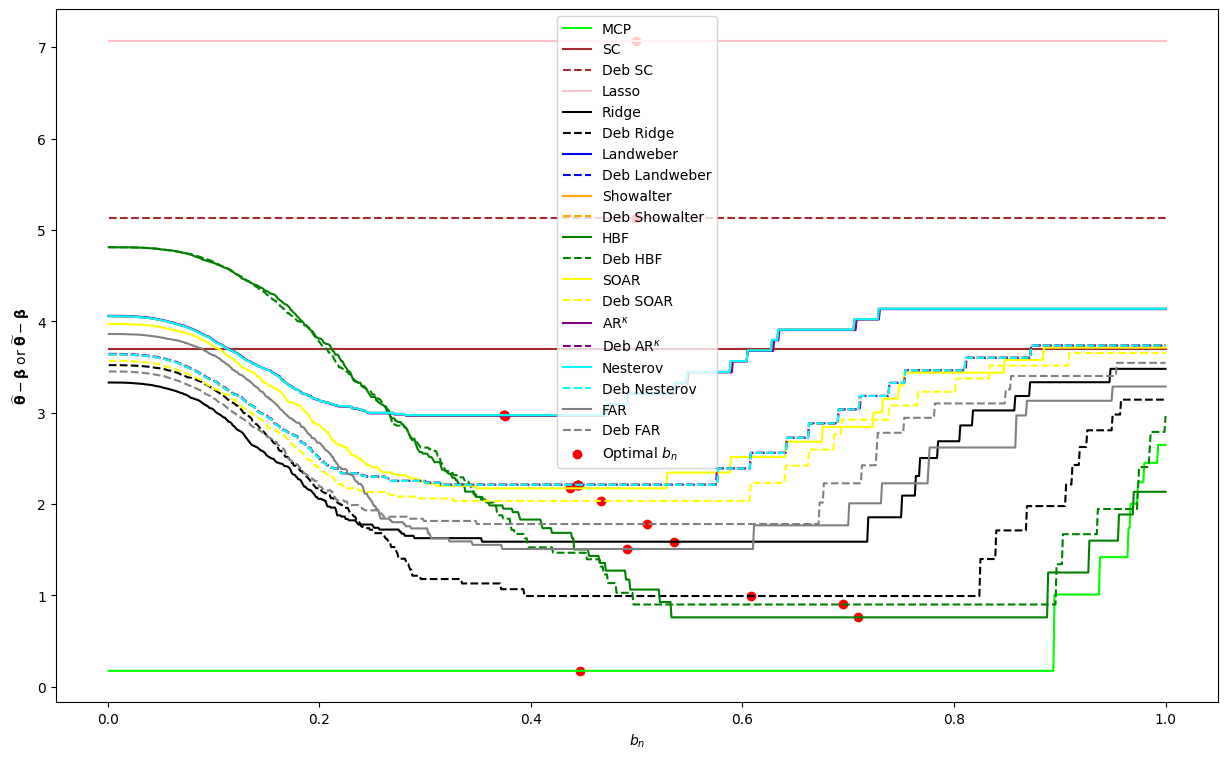

In [80]:
import seaborn as sns

sns.set_palette("pastel")
# 画图
import matplotlib.pyplot as plt



plt.figure(figsize=(15, 9))
# plt.plot(df['bn'], df['norm_LSbn'], label='LS', color='gold', linestyle='-')
plt.plot(df['bn'], df['norm_MCPbn'], label='MCP', color='lime', linestyle='-')
plt.plot(df['bn'], df['norm_cut'], label='SC', color='brown', linestyle='-')
plt.plot(df['bn'], df['norm_cut_debias'], label='Deb SC', color='brown', linestyle='--')
plt.plot(df['bn'], df['norm_Lassobn'], label='Lasso', color='pink', linestyle='-')
plt.plot(df['bn'], df['norm_Ridgebn'], label='Ridge', color='black',linestyle='-')
plt.plot(df['bn'], df['norm_Ridge_debiasbn'], label='Deb Ridge', color='black',linestyle='--')
plt.plot(df['bn'], df['norm_Landweberbn'], label='Landweber', color='blue', linestyle='-')
plt.plot(df['bn'], df['norm_Landweber_debiasbn'], label='Deb Landweber', color='blue',linestyle='--')
plt.plot(df['bn'], df['norm_showalterbn'], label='Showalter', color='orange', linestyle='-')
plt.plot(df['bn'], df['norm_showalter_debiasbn'], label='Deb Showalter', color='orange', linestyle='--')
plt.plot(df['bn'], df['norm_hbfbn'], label='HBF', color='green', linestyle='-')
plt.plot(df['bn'], df['norm_hbf_debiasbn'], label='Deb HBF', color='green', linestyle='--')
plt.plot(df['bn'], df['norm_secondbn'], label='SOAR', color='yellow', linestyle='-')
plt.plot(df['bn'], df['norm_second_debiasbn'], label='Deb SOAR', color='yellow', linestyle='--')
plt.plot(df['bn'], df['norm_ARkbn'], label=r'AR$^\kappa$', color='purple', linestyle='-')
plt.plot(df['bn'], df['norm_ARk_debiasbn'], label=r'Deb AR$^\kappa$', color='purple', linestyle='--')
plt.plot(df['bn'], df['norm_Nesterovbn'], label='Nesterov', color='cyan', linestyle='-')
plt.plot(df['bn'], df['norm_Nesterov_debiasbn'], label='Deb Nesterov', color='cyan', linestyle='--')
plt.plot(df['bn'], df['norm_Fracbn'], label='FAR', color='gray', linestyle='-')
plt.plot(df['bn'], df['norm_Frac_debiasbn'], label='Deb FAR', color='gray', linestyle='--')
plt.xlabel(r'$b_n$')
plt.ylabel(r'$\widehat{\mathbf{\theta}}-\mathbf{\beta}$ or $\widetilde{\mathbf{\theta}}-\mathbf{\beta}$')
# 假设 df 是已经定义并包含必要数据的 pandas 数据框
plt.scatter(results_array[2:, 1], results_array[2:, 0], color='red', label=r'Optimal $b_n$') 
plt.legend()
# plt.legend(loc='upper left')
# plt.savefig('PartLaplace10.eps', format='eps')
plt.savefig('Laplace10.eps', format='eps')
# plt.savefig('Normal10.eps', format='eps')
# plt.savefig('PartNormal10.eps', format='eps')
# plt.savefig('Laplace15.eps', format='eps')
# plt.savefig('Normal15.eps', format='eps')
# 显示图例
plt.show()



In [82]:
print(f"LS                   & {norm_LS:.4f} &  ~    &  ~           & {results_array[0, 0]:.4f} &   ~        & {results_array[0, 1]:.4f} & ~      \\\\")
print(f"SC                   & {norm_cut:.4f} &  ~    &  {norm_cut_debias:.4f}  & {results_array[1, 0]:.4f} & {results_array[2, 0]:.4f} & {results_array[1, 1]:.4f} & {results_array[2, 1]:.4f} \\\\")
print(f"Lasso                & {norm_Lasso:.4f} &  ~    &  ~           & {results_array[3, 0]:.4f} &   ~        & {results_array[3, 1]:.4f} & ~      \\\\")
print(f"Ridge                & {norm_Ridge:.4f} &  ~    &  {norm_Ridge_debias:.4f}  & {results_array[4, 0]:.4f} & {results_array[5, 0]:.4f} & {results_array[4, 1]:.4f} & {results_array[5, 1]:.4f} \\\\")
print(f"Landweber            & {norm_Landweber:.4f}   &  {k_Landweber} &  {norm_Landweber_debias:.4f}    & {results_array[6, 0]:.4f}   & {results_array[7, 0]:.4f}   & {results_array[6, 1]:.4f} & {results_array[7, 1]:.4f} \\\\")
print(f"Showalter            & {norm_showalter:.4f}   &  {k_showalter} &  {norm_showalter_debias:.4f}    & {results_array[8, 0]:.4f}   & {results_array[9, 0]:.4f}   & {results_array[8, 1]:.4f} & {results_array[9, 1]:.4f} \\\\")
print(f"HBF                  & {norm_hbf:.4f}   &  {k_hbf}  &  {norm_hbf_debias:.4f}    & {results_array[10, 0]:.4f}   & {results_array[11, 0]:.4f}   & {results_array[10, 1]:.4f} & {results_array[11, 1]:.4f} \\\\")
print(f"$\\textrmAR^\\kappa$ & {norm_ARk:.4f}   &  {k_ARk}  &  {norm_ARk_debias:.4f}    & {results_array[12, 0]:.4f}   & {results_array[13, 0]:.4f}   & {results_array[12, 1]:.4f} & {results_array[13, 1]:.4f} \\\\")
print(f"SOAR                 & {norm_second:.4f}   &  {k_second}  &  {norm_second_debias:.4f}    & {results_array[14, 0]:.4f}   & {results_array[15, 0]:.4f}   & {results_array[14, 1]:.4f} & {results_array[15, 1]:.4f} \\\\")
print(f"Nesterov             & {norm_Nesterov:.4f}   &  {k_Nesterov} &  {norm_Nesterov_debias:.4f}    & {results_array[16, 0]:.4f}   & {results_array[17, 0]:.4f}   & {results_array[16, 1]:.4f} & {results_array[17, 1]:.4f} \\\\")
print(f"FAR                  & {norm_Frac:.4f}   &  {k_Frac}  &  {norm_Frac_debias:.4f}    & {results_array[18, 0]:.4f}   & {results_array[19, 0]:.4f}   & {results_array[18, 1]:.4f} & {results_array[19, 1]:.4f} \\\\   \\hline")
print(f"MCP                  & {norm_MCP:.4f} &  ~    &  ~           & {results_array[20, 0]:.4f} &   ~        & {results_array[20, 1]:.4f} & ~      \\\\")


LS                   & 76.4025 &  ~    &  ~           & 75.6854 &   ~        & 0.9970 & ~      \\
SC                   & 3.6947 &  ~    &  5.1280  & 3.6947 & 5.1280 & 0.4995 & 0.4995 \\
Lasso                & 7.0711 &  ~    &  ~           & 7.0711 &   ~        & 0.4995 & ~      \\
Ridge                & 3.3313 &  ~    &  3.5217  & 1.5887 & 0.9941 & 0.5350 & 0.6080 \\
Landweber            & 4.0568   &  2475 &  3.6395    & 2.9736   & 2.2121   & 0.3750 & 0.4445 \\
Showalter            & 4.0566   &  2476 &  3.6392    & 2.9734   & 2.2114   & 0.3750 & 0.4445 \\
HBF                  & 4.8117   &  926  &  4.8121    & 0.7607   & 0.9015   & 0.7095 & 0.6955 \\
$\textrmAR^\kappa$ & 4.0615   &  697  &  3.6448    & 2.9672   & 2.2130   & 0.3755 & 0.4440 \\
SOAR                 & 3.9725   &  181  &  3.5689    & 2.1732   & 2.0355   & 0.4375 & 0.4660 \\
Nesterov             & 4.0568   &  2476 &  3.6394    & 2.9736   & 2.2119   & 0.3750 & 0.4445 \\
FAR                  & 3.8619   &  391  &  3.4521    & 1